In [28]:
%matplotlib inline
from matplotlib import style 
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd
import datetime as dt
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base  #use automap instead of declarative base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float, Date

In [31]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# conn = engine.connect() 

In [32]:
# reflect an existing database into a new model  ## METHOD 3
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [33]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [36]:
#Find the most recent date from Measurement
recent_date = session.query(Measurement).\
    order_by(Measurement.date.desc()).limit(1)
    
for date in recent_date:
    recent = date.date
    most_recent= dt.datetime.strptime(recent, "%Y-%m-%d")
    
# Calculate the date 1 year ago from the last data point in the database
one_yr_ago = most_recent - dt.timedelta(365)
print(f"Most recent date: ", most_recent)
print(f"One-year ago date: ", one_yr_ago)

Most recent date:  2017-08-23 00:00:00
One-year ago date:  2016-08-23 00:00:00


In [79]:
# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.station, Measurement.prcp,  Measurement.tobs).\
    filter(Measurement.date >= one_yr_ago).order_by(Measurement.date, Measurement.station).all() # ascending order
rain_df = pd.DataFrame(rain_data).set_index('date')  #index by date
rain_df.dropna().drop_duplicates   #remove missing data and duplicates
rain_df.head()

,station,prcp,tobs
date,,,
2016-08-24,USC00513117,2.15,76.0
2016-08-24,USC00514830,2.28,80.0
2016-08-24,USC00516128,1.45,74.0
2016-08-24,USC00517948,NaN,78.0
2016-08-24,USC00519281,2.15,77.0


In [96]:
rain_df.shape

(2223, 3)

In [112]:
rain_day_df = rain_df['prcp'].groupby(['date']).sum()
rain_day_df

date
2016-08-24     9.33
2016-08-25     0.54
2016-08-26     0.10
2016-08-27     0.32
2016-08-28     3.10
2016-08-29     1.46
2016-08-30     0.07
2016-08-31     3.18
2016-09-01     0.03
2016-09-02     0.25
2016-09-03     1.27
2016-09-04     1.38
2016-09-05     0.34
2016-09-06     1.23
2016-09-07     2.00
2016-09-08     0.46
2016-09-09     1.07
2016-09-10     1.40
2016-09-11     1.25
2016-09-12     1.54
2016-09-13     2.71
2016-09-14    14.28
2016-09-15     4.96
2016-09-16     0.82
2016-09-17     0.68
2016-09-18     0.53
2016-09-19     0.32
2016-09-20     1.03
2016-09-21     1.17
2016-09-22     1.44
              ...  
2017-07-25     0.61
2017-07-26     0.50
2017-07-27     0.01
2017-07-28     0.77
2017-07-29     0.61
2017-07-30     0.30
2017-07-31     0.00
2017-08-01     0.14
2017-08-02     0.30
2017-08-03     0.07
2017-08-04     0.06
2017-08-05     0.06
2017-08-06     0.00
2017-08-07     0.05
2017-08-08     0.44
2017-08-09     0.15
2017-08-10     0.07
2017-08-11     0.00
2017-08-12     

In [113]:
# Set x axis and tick locations
x_axis = np.arange(len(rain_day_df))
tick_locations = [value+0.4 for value in x_axis]

In [114]:
# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis, rain_day_df["prcp"], color='b', alpha=0.9, align="edge")
plt.xticks(tick_locations, rotation="vertical")
plt.xlabel("Date")
plt.ylabel("Rain inches")
plt.title ("Hawaii Precipitation")

fig = plt.figure()
plt.savefig("Images/Precipitation.png")
plt.show()

KeyError: 'prcp'

<Figure size 1440x216 with 0 Axes>

In [41]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'{stations} weather stations')

9 weather stations


In [43]:
# List the stations and the counts in descending order.
station_data = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.name).\
    order_by(func.count(Measurement.id).desc()).all()
station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
print(f"Most active station: {station_data[0][0]}")

Most active station: USC00519281


In [45]:
# Using the station id from the previous query, 
active_station = 'USC00519281'

# Calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()

print(f"Lowest Temperature: {temps[0][0]} F")
print(f"Highest Temperature: {temps[0][1]} F")
print(f"Average Temperature: {round(temps[0][2], 2)} F")

Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66 F


In [46]:
one_yr_ago  # one year ago date 

datetime.datetime(2016, 8, 23, 0, 0)

In [47]:
# Choose the station with the highest number of temperature observations. USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

USC00519281_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').filter(Measurement.date >= one_yr_ago).all() # worked with date format

USC00519281_df = pd.DataFrame(USC00519281_data)
USC00519281_df.shape

(351, 3)

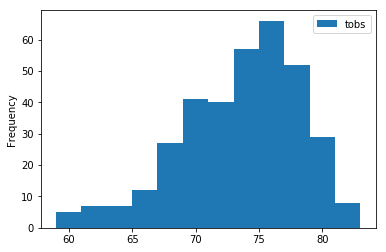

In [60]:
tobs_USC00519281_df = pd.DataFrame(USC00519281_df['tobs'])
tobs_USC00519281_df.plot.hist(bins=12)

In [50]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [52]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [53]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [54]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [55]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [56]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [57]:
# Plot the daily normals as an area plot with `stacked=False`


In [58]:
# start date
start_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(start_date)
one_yr_date = start_date - dt.timedelta(days=365)
print(one_yr_ago)

#start_date = np.ravel(start_date)[0] 
# group by records into month
records = session.query(Measurements.date, func.avg(Measurements.prcp))\
          .group_by(func.strftime('%Y-%m', Measurements.date))\
          .order_by(Measurements.date.desc()).limit(12).all()

# end_date is 12 month later
end_date = np.ravel(records[11])[0]
print(end_date)

NameError: name 'Measurements' is not defined

In [ ]:
extend_existing=True

In [ ]:
class Station(Base):
    __tablename__ = 'station'
    id = Column(Integer, primary_key=True)
    station = Column(String(11))
    name = Column(String(50))
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)